In [1]:
!pip install keras
!pip install tensorflow

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

Using TensorFlow backend.


In [3]:
test_img_fnames = os.listdir('data/test')
train_img_fnames = os.listdir('data/train')

# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [20]:
!pip install imageio

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [27]:
from skimage import data
from skimage.transform import resize

In [32]:
import imageio
def load_img(filename):
    array = imageio.imread(filename)
    return misc.imresize(array, (224, 224, 3))

In [33]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames]
test_imgs = np.stack(test_imgs)

In [34]:
train_imgs = [load_img(os.path.join('data/train', fname)) for fname in train_img_fnames]
train_imgs = np.stack(train_imgs)

In [271]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [ ]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
VGG16.summary()

In [ ]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

In [ ]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

In [ ]:
# Save featurizations
import pickle
with open('featurized_train_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

# Load featurizations

In [37]:
import pickle
with open('featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create you network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [272]:
train_imgs = train_imgs[:10000]
train_labels = train_labels[:10000]

In [264]:
train_imgs.shape

(1000, 224, 224, 3)

In [304]:
from keras.layers.convolutional import Conv2D
model = Sequential()
model.add(Conv2D(32, (5, 5),
                 input_shape=(7, 7, 512)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('softmax'))
model.add(Dense(1, activation='sigmoid'))


In [305]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 3, 3, 32)          409632    
_________________________________________________________________
flatten_21 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               28900     
_________________________________________________________________
activation_15 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 438,633
Trainable params: 438,633
Non-trainable params: 0
_________________________________________________________________


# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [306]:
model.compile(loss='binary_crossentropy', optimizer='sgd')

In [307]:
model.fit(featurized_training_data[:10000], train_labels, batch_size=None, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 17s 2ms/step - loss: 0.6491


Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [308]:
predictions = np.round(model.predict(featurized_test_data))

In [309]:
predictions

array([[ 0.],
       [ 1.],
       [ 1.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [314]:
with open('test_labels.txt', 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = int(val[0])
        f.write(str(i))
        f.write(',')
        f.write(str(prediction))
        f.write('\n')

# Part 2

In [277]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [278]:
featurized_training_data.shape

(10000, 7, 7, 512)

In [279]:
original_imgs = train_imgs[:500]
featurized = featurized_training_data[:500]

In [280]:
original_imgs.shape

(500, 224, 224, 3)

In [281]:
224*224*3

150528

In [282]:
original_imgs = original_imgs.reshape((500, 150528))
featurized = featurized.reshape((500, 25088))

Run PCA with 2 components on the original images

In [283]:
pca = PCA(n_components=2)
pca_orig = pca.fit(original_imgs)


Run PCA with 2 components on the featurizations

In [284]:
pca_new = PCA(n_components=2)
pca_featurized = pca_new.fit(featurized)


In [285]:
original_imgs.shape

(500, 150528)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [286]:
projected_orig_imgs = pca_orig.transform(original_imgs)

In [287]:
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [288]:
labels = train_labels[:500]
x = labels
cat_inds = np.where(x==1)
dog_inds = np.where(x==0)

Plot the PCA of the original images and the PCA of the featurization

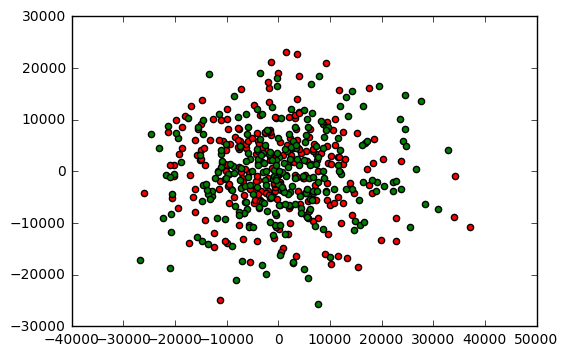

In [289]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

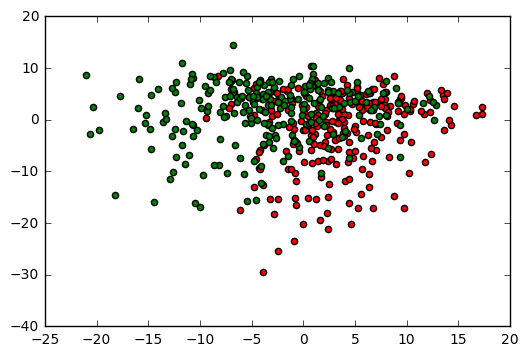

In [290]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')